In [ ]:
import math

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.features as rfeatures
import rasterio.plot as rplot
import contextily
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from streetscapes import conf

In [6]:
data_dir = conf.DATA_DIR / "data"
parquet_dir =  data_dir / "parquet"

In [7]:
df = pd.read_parquet(parquet_dir / f"joined_amsterdam_side.parquet")

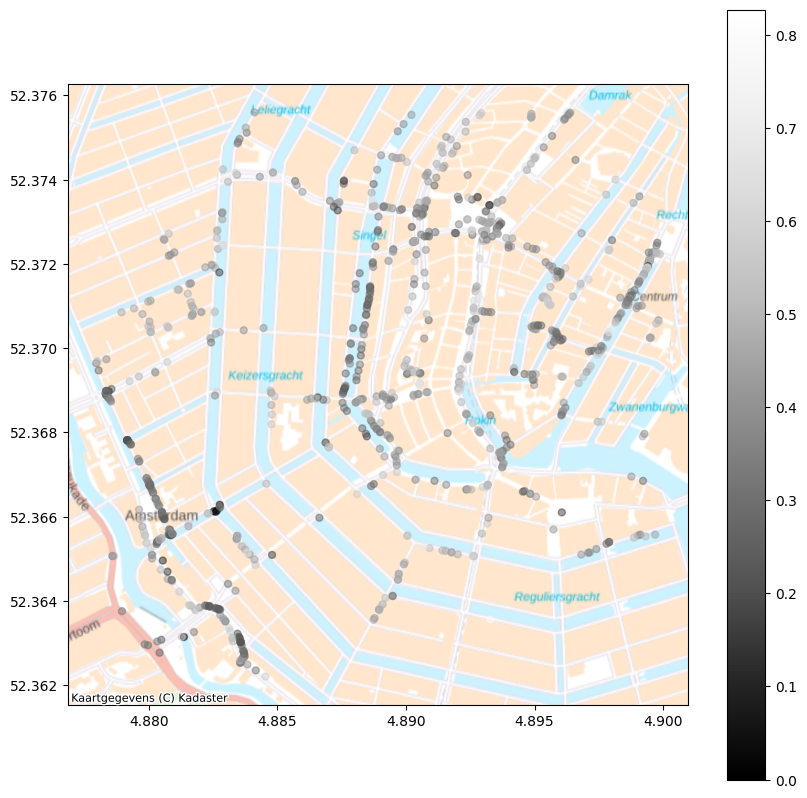

In [8]:
gdf = gpd.GeoDataFrame(df.building_mean, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
ax = gdf.plot(column='building_mean', cmap='Greys_r', legend=True, markersize=25, figsize=(10, 10), alpha=0.5)
# contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.OpenStreetMap.Mapnik)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.pastel)


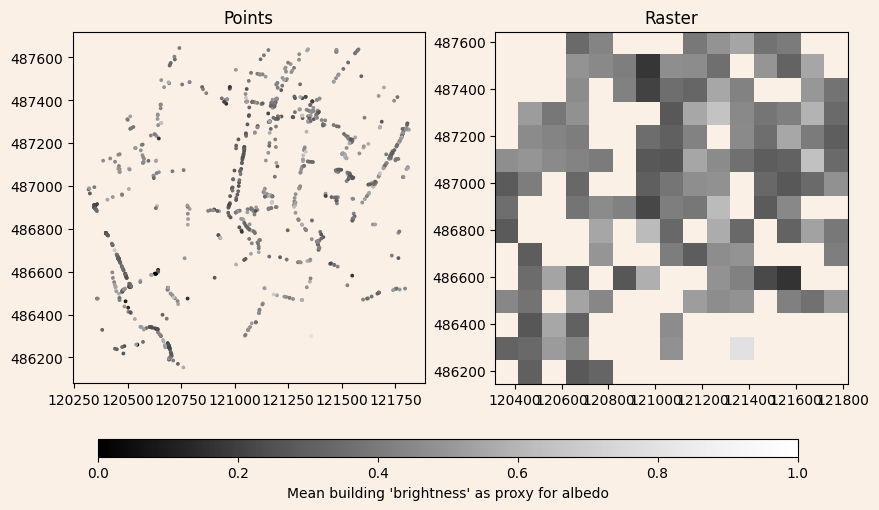

In [40]:
# Target grid in meters (?)
amsterdam_projected = gdf.to_crs(28992)

# To rasterise points, you first need to create a template raster 
# with the same extents and CRS as your input point data. 
bounds = amsterdam_projected.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)

# Calculate output shape
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)

# Create pairs of coordinates to value
g = [(g, v) for g, v in amsterdam_projected[['geometry', 'building_mean']] \
        .dropna(subset='building_mean')
        .to_numpy() \
        .tolist()]

# Rasterise
raster = rfeatures.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    fill=np.nan

)

# Plot result
cmap = plt.get_cmap('Greys_r')
norm = mcolors.Normalize(0, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
amsterdam_projected.plot(column='building_mean', ax=ax1, cmap=cmap, norm=norm, markersize=3, )
rplot.show(raster, transform=transform, ax=ax2, cmap=cmap, norm=norm)

cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
cb.set_label("Mean building 'brightness' as proxy for albedo")

ax1.set_title('Points')
ax2.set_title('Raster')
ax1.set_facecolor('linen')
ax2.set_facecolor('linen')
fig.patch.set_facecolor('linen')  # Change entire figure background

plt.show()